# Homework 4
## Lauren Bassett jme9rt
On my honor as a student, I have neither given nor recieved unauthorized aid on this assignment. 

# Pre-processing, import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm 
import seaborn as sns
import theano
import arviz as az 
from pymc3 import forestplot, traceplot, plot_posterior
from scipy.stats import multivariate_normal
from itertools import combinations

np.random.seed(6040)

coffee = pd.read_csv('sales-ds6040sum2021.csv')
wine_testing = pd.read_csv('whitewine-testing-ds6040.csv')
wine_training = pd.read_csv('whitewine-training-ds6040-1.csv')

# Part 1 - Bayesian Hierarchical Modelling 


Questions: 
How does conscientiousness and neuroticism impact the sales of coffee and food, and are coffee and
food impacted differently?

Once you control for the personality characteristics of the store managers, what stores should be
performing well? (i.e. the rest of the employees might be great, but the store manager might be bringing
sales down)

### Approach Step 1: Data Exploration

In [2]:
coffee.head()

,sales,food,con,neur,store
0,1.363821,0,0.216553,1.290224,0
1,-1.119747,1,0.216553,1.290224,0
2,-0.180141,0,0.216553,1.290224,0
3,-2.282334,1,0.216553,1.290224,0
4,0.673304,0,0.216553,1.290224,0


Before I do anything, I use the .head() function to get a preview of the data, and what we can expect. This doesn't give much information right away, but it gives me an overall idea of what the data looks like.

We know our quantitiative variables are:  
- sales
- con
- neur
  
Our categorical variables are:  
- food
- store 

In [3]:
coffee.groupby(['store', 'food']).mean('sales')

sales       con      neur
store food                              
0     0    -0.157253  0.216553  1.290224
      1    -1.442931  0.216553  1.290224
1     0     0.250400 -0.135665 -2.276493
      1    -1.178097 -0.135665 -2.276493
2     0     0.238989  0.738900  0.093054
      1    -1.284719  0.738900  0.093054
3     0     1.124880 -0.579423 -0.457344
      1    -0.386966 -0.579423 -0.457344
4     0     1.345538 -0.976866 -0.865172
      1    -0.587611 -0.976866 -0.865172
5     0     0.907453 -0.219433 -1.315683
      1    -1.173526 -0.219433 -1.315683
6     0     0.469321 -0.130894 -0.874896
      1    -0.214635 -0.130894 -0.874896
7     0     0.531118 -2.018870 -1.069713
      1    -2.611578 -2.018870 -1.069713
8     0    -0.398823 -0.408856  0.374658
      1    -0.387042 -0.408856  0.374658
9     0    -1.385427 -0.568532  0.966242
      1    -3.076568 -0.568532  0.966242
10    0    -0.389983  0.410372  0.330495
      1    -0.336451  0.410372  0.330495
11    0    -0.805283 -0.506002 -0.114954
      1    -1.693260 -0.506002 -0.114954
12    0     1.789909 -0.717169 -0.036987
      1    -1.629684 -0.717169 -0.036987
13    0     1.042030 -0.915437  0.420692
      1     0.400225 -0.915437  0.420692
14    0     4.055752  0.587351 -0.646036
      1     4.465717  0.587351 -0.646036
15    0     1.087828  0.139971 -0.173394
      1     1.409617  0.139971 -0.173394
16    0    -0.909599 -0.501073 -0.953021
      1    -2.129063 -0.501073 -0.953021
17    0     1.337243  0.325928  0.796620
      1     1.880833  0.325928  0.796620
18    0    -0.691490 -0.201251  2.382800
      1    -1.821823 -0.201251  2.382800
19    0    -0.248919  0.306285 -0.070093
      1    -1.223730  0.306285 -0.070093

I also want to see the mean sales values for each store, broken down by food offering. The con and neur variables are consistent across each store. 

<AxesSubplot:>

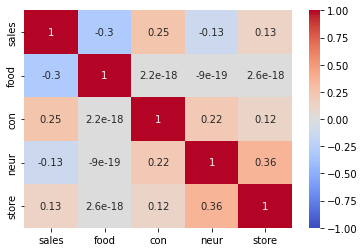

In [4]:
sns.heatmap(coffee.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

One of the preliminary visuals I want to generate is a correlation matrix between the variables. One of the key takeaways before we move forward with modeling, is that it appears there is a positive correlation between sales and conscientiousness and a negative correlation between sales and neuroticism. This will be something we continue to explore as we move forward. 

### Approach Step 2: Data Preparation for Modeling
Before we do any hierachical modeling, we must first prepare the variables properly. Below, I declare each variable as a seperate object to be used in the hierachical model. 

In [5]:
stores = len(coffee.store.unique())
store = coffee.store.values
con = coffee.con.values
food = coffee.food.values
neur = coffee.neur.values
sales = coffee.sales.values

The first model we run is going to be pretty much identical to what is provided in the companion, the only changes I am making are in the variable names and variable being referenced in the shape of the offset. 




### Approach Step 3: Run first model
### Prior Selection: In all models, I am using a prior of zero. I am chosing this becauseI don't have any information about the patterns in the data at this point. The other reason I am chosing a prior of zero is that it appears that the sales are on either side of 0, so it seems like a good place to estimate.

In [6]:
with pm.Model() as hierarchical_model:
    
    # Priors for the fixed effects
    # a - overall intercept, level of sales at mean levels of con and neur
    mu_a = pm.Normal('mu_a', mu=0., sigma=2)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    
    mu_b = pm.Normal('mu_b', mu=0., sigma=1)
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)
    
        
    mu_c = pm.Normal('mu_c', mu=0., sigma=1)
    sigma_c = pm.HalfCauchy('sigma_c', beta=0.5)
    
        
    mu_d = pm.Normal('mu_d', mu=0., sigma=1)
    sigma_d = pm.HalfCauchy('sigma_d', beta=0.5)
    
        
    mu_e = pm.Normal('mu_e', mu=0., sigma=1)
    sigma_e = pm.HalfCauchy('sigma_e', beta=0.5)
    
        
    mu_f = pm.Normal('mu_f', mu=0., sigma=1)
    sigma_f = pm.HalfCauchy('sigma_f', beta=0.5)

    a_offset = pm.Normal('a_offset',  mu=0, sd=2, shape=stores)
    a=pm.Deterministic("a", mu_a+a_offset*sigma_a)
    b_offset = pm.Normal('b_offset',  mu=0, sd=2, shape=stores)
    b=pm.Deterministic("b", mu_b+b_offset*sigma_b)

    c= pm.Normal('c',mu=mu_c,sigma=sigma_c)
    d= pm.Normal('d',mu=mu_d,sigma=sigma_d)
    e= pm.Normal('e',mu=mu_e,sigma=sigma_e)
    f= pm.Normal('f',mu=mu_f,sigma=sigma_f)
    
    sigma_y = pm.HalfCauchy('sigma_y', beta=1)
    y_hat = a[store] + b[store]*coffee.food + c*coffee.con +d*coffee.con*coffee.food+ e*coffee.neur + f*coffee.neur*coffee.food
    y_like = pm.Normal('y_like', mu=y_hat, sd = sigma_y, observed = sales)
    

In [7]:
with hierarchical_model:
    hierarchical_trace = pm.sample(1000, n_init=50000, tune=1000, step=pm.NUTS(target_accept = 0.99))

/var/folders/0r/hry4zr3s1m57hjbkgslzxvnr0000gp/T/ipykernel_51520/315265484.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(1000, n_init=50000, tune=1000, step=pm.NUTS(target_accept = 0.99))
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, f, e, d, c, b_offset, a_offset, sigma_f, mu_f, sigma_e, mu_e, sigma_d, mu_d, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


/Users/lbassett/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lbassett/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lbassett/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lbassett/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 206 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.

### Findings

/Users/lbassett/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/lbassett/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'mu_d'}>,
        <AxesSubplot:title={'center':'mu_d'}>],
       [<AxesSubplot:title={'center':'mu_e'}>,
        <AxesSubplot:title={'center':'mu_e'}>],
       [<AxesSubplot:title={'center':'mu_f'}>,
        <AxesSubplot:title={'center':'mu_f'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'e'}>,
  

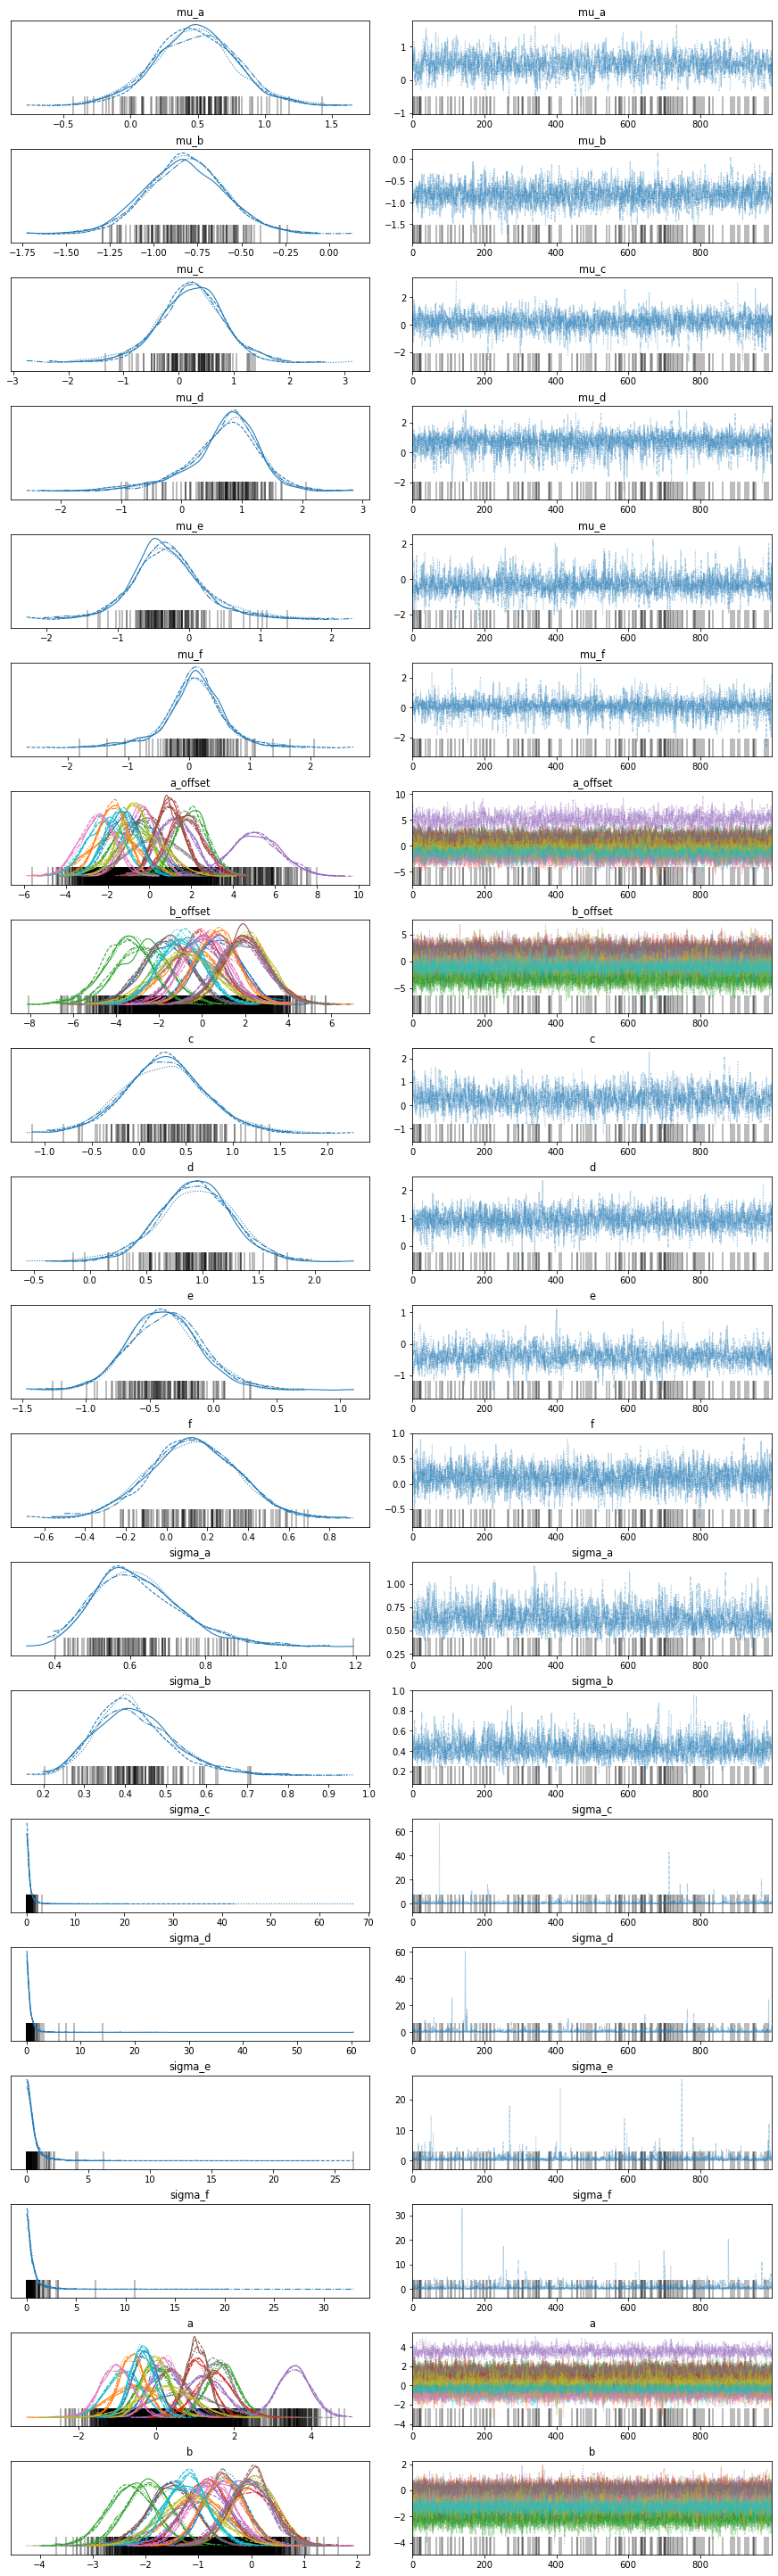

In [8]:
az.plot_trace(hierarchical_trace)

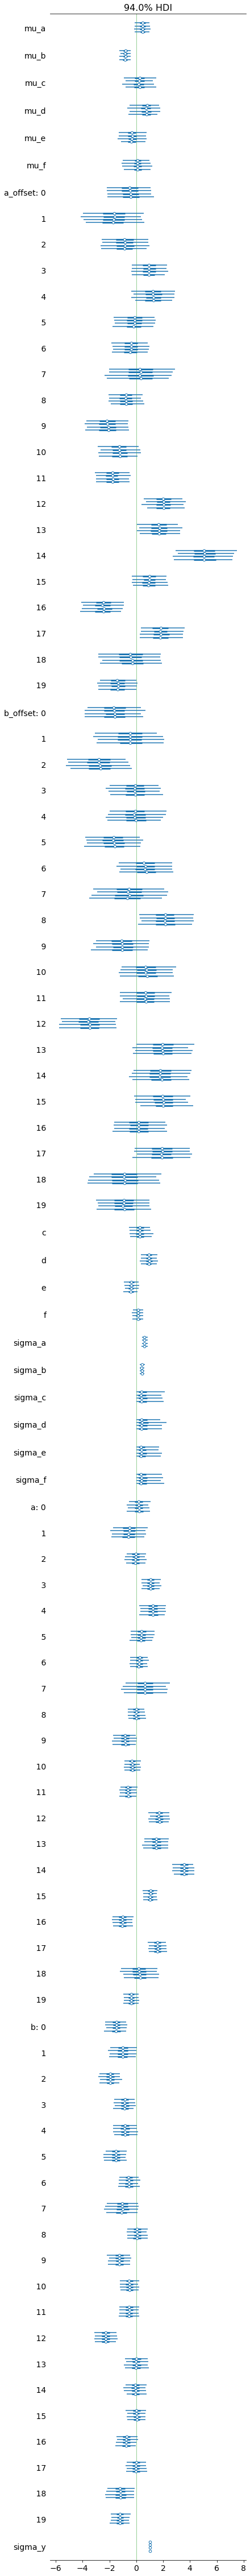

In [9]:
#Forest Plots can be quite useful in visualizing the posterior distributions across the clustering units.
with hierarchical_model:
    az.plot_forest(hierarchical_trace, rope=(0, 0))

### Diagnostic

In [29]:
with hierarchical_model:
    diag = pm.summary(hierarchical_trace)
diag


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,0.476,0.305,-0.164,1.009,0.008,0.006,1299.0,1644.0,1.0
mu_b,-0.817,0.225,-1.253,-0.408,0.005,0.004,1910.0,2029.0,1.0
mu_c,0.206,0.606,-0.899,1.396,0.013,0.010,2110.0,1951.0,1.0
mu_d,0.699,0.601,-0.515,1.780,0.012,0.009,2602.0,2017.0,1.0
mu_e,-0.291,0.531,-1.247,0.810,0.011,0.009,2193.0,2251.0,1.0
...,...,...,...,...,...,...,...,...,...
b[16],-0.741,0.421,-1.478,0.100,0.007,0.005,4015.0,3184.0,1.0
b[17],-0.014,0.412,-0.785,0.742,0.006,0.006,4695.0,3502.0,1.0
b[18],-1.177,0.561,-2.197,-0.081,0.011,0.008,2597.0,2766.0,1.0
b[19],-1.206,0.378,-1.888,-0.473,0.005,0.004,5361.0,3002.0,1.0


### Summary:

How does conscientiousness and neuroticism impact the sales of coffee and food, and are coffee and food impacted differently?

The behavior of the store manager does impact the sales of coffee and food, and they are impacted differently. 
C+D refer to concientiousness, and E+F Refer to neuroticism. 
The forest plot shows a similar story to what we found in the correlation matrix, a conscientious employer has a positive affect on sales, where a neurotic employer has a negative affect on sales. 


Once you control for the personality characteristics of the store managers, what stores should be performing well? (i.e. the rest of the employees might be great, but the store manager might be bringing sales down)

Once you control for the behavior of the manager, you are left with the intercept and food sales. 



### Part 2: Bayesian Model Averaging with Logistic Regression (40 points)
1. First, revisit your HW2 and calculate the misclassification rate and the cross tabs for 3 variable models
that used flat priors that performed best on the testing data. You will have 1 model for LDA and 1
model for QDA.

In [10]:
class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot
    
    

In [11]:
class QDA(LDA):
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 

In [12]:
wine_training.wine_quality.value_counts()
wine_training.head()
training_counts = wine_training['wine_quality'].value_counts().to_frame()
total_training = training_counts.sum()[0]

Flat Priors: LDA

In [13]:
flat_priors = [1/3, 1/3, 1/3]
LDA_non_informative = LDA(wine_training, 'wine_quality', priors = flat_priors)
print('+-----Non-Informative-Priors----+')
print('\t-Training Dataset-')
Non_Inform_Train_MCR = LDA_non_informative.misclass_rate()
print("Mis-Classification Rate:",Non_Inform_Train_MCR)
print("** Cross Tab **")
print(LDA_non_informative.misclass_xtabs())
print('----------------------------------')
print("\t-Testing Dataset-")
Non_Inform_Test_MCR = LDA_non_informative.misclass_rate(wine_testing)
print("Mis-Classification Rate:",Non_Inform_Test_MCR)
print("** Cross Tab **")
print(LDA_non_informative.misclass_xtabs(wine_testing))

+-----Non-Informative-Priors----+
	-Training Dataset-
Mis-Classification Rate: 0.49496538703587156
** Cross Tab **
True Class   A    C    F
MAP Class               
A           69  687   62
C           22  800  202
F            9  591  736
----------------------------------
	-Testing Dataset-
Mis-Classification Rate: 0.48546511627906974
** Cross Tab **
True Class   A    C    F
MAP Class               
A           56  348   43
C           15  381  149
F            9  271  448


Find Features LDA

In [14]:
#Create List of all possible combinations of 3 features
def find_three_combo(priors):
    combo_of_three_features = [list(x) for x in combinations(wine_training.drop('wine_quality', axis=1), 3)]

    LDA_train_results = []
    LDA_test_results = []

    #Iterate through all possible combinations of three. 
    for combination in combo_of_three_features:
        current_columns = combination + ['wine_quality']
        train_three_feat = wine_training[current_columns]
        test_three_feat = wine_testing[current_columns]
        #print(train_three_feat)
        LDA_3 = LDA(train_three_feat, 'wine_quality', priors=priors)
        train_misclass = LDA_3.misclass_rate()
        test_misclass = LDA_3.misclass_rate(test_three_feat)
        LDA_train_results.append((current_columns, train_misclass))
        LDA_test_results.append((current_columns, test_misclass))

    return(LDA_train_results, LDA_test_results)

Print Best Features, LDA

In [15]:
LDA_train, LDA_test = find_three_combo(priors=flat_priors)
train_final = pd.DataFrame(LDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(LDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()
print("Training:\nThe Combination of Features that Provides the lowest mis-class rate:", train_min['Combination'][0])
print("The corresponding mis-class rate is:" ,train_min['Misclass_Rate'][0])
print()
test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()
print("Testing:\nThe Combination of Features that Provides the lowest mis-class rate:", test_min['Combination'][0])
print("The corresponding mis-class rate is:", test_min['Misclass_Rate'][0])
LDA_best_misclass_train = LDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors=flat_priors)
LDA_best_misclass_test = LDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors=flat_priors)

Training:
The Combination of Features that Provides the lowest mis-class rate: ['volatile.acidity', 'residual.sugar', 'alcohol', 'wine_quality']
The corresponding mis-class rate is: 0.5050346129641283

Testing:
The Combination of Features that Provides the lowest mis-class rate: ['volatile.acidity', 'density', 'alcohol', 'wine_quality']
The corresponding mis-class rate is: 0.4877906976744186


Graphs:

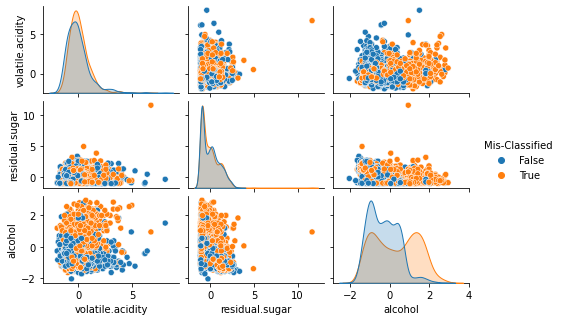

In [16]:
LDA_best_misclass_train = LDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors=flat_priors)
LDA_best_misclass_test = LDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors=flat_priors)
LDA_best_misclass_train.misclass_pairplot()

Flat Priors, QDA

In [17]:
QDA_non_informative = QDA(wine_training, 'wine_quality', priors = flat_priors)
print('+-----Non-Informative-Priors----+')
print('\t-Training Dataset-')
Non_Inform_Train_MCR = QDA_non_informative.misclass_rate()
print("Mis-Classification Rate:",Non_Inform_Train_MCR)
print("** Cross Tab **")
print(QDA_non_informative.misclass_xtabs())
print('----------------------------------')
print("\t-Testing Dataset-")
Non_Inform_Test_MCR = QDA_non_informative.misclass_rate(wine_testing)
print("Mis-Classification Rate:",Non_Inform_Test_MCR)
print("** Cross Tab **")
print(QDA_non_informative.misclass_xtabs(wine_testing))

+-----Non-Informative-Priors----+
	-Training Dataset-
Mis-Classification Rate: 0.5088105726872247
** Cross Tab **
True Class   A    C    F
MAP Class               
A           87  828   90
C            9  799  235
F            4  451  675
----------------------------------
	-Testing Dataset-
Mis-Classification Rate: 0.5186046511627906
** Cross Tab **
True Class   A    C    F
MAP Class               
A           58  414   54
C           21  381  197
F            1  205  389


Get all features, QDA:

In [18]:
#Create List of all possible combinations of 3 features
def find_three_combo_QDA(priors):
    combo_of_three_features = [list(x) for x in combinations(wine_training.drop('wine_quality', axis=1), 3)]

    QDA_train_results = []
    QDA_test_results = []

    #Iterate through all possible combinations of three. 
    for combination in combo_of_three_features:
        current_columns = combination + ['wine_quality']
        train_three_feat = wine_training[current_columns]
        test_three_feat = wine_testing[current_columns]
        #print(train_three_feat)
        QDA_3 = QDA(train_three_feat, 'wine_quality', priors=priors)
        train_misclass = QDA_3.misclass_rate()
        test_misclass = QDA_3.misclass_rate(test_three_feat)
        QDA_train_results.append((current_columns, train_misclass))
        QDA_test_results.append((current_columns, test_misclass))

    return(QDA_train_results, QDA_test_results)
 
 

Print Best Features, QDA

In [19]:
QDA_train, QDA_test = find_three_combo_QDA(priors=flat_priors)
train_final = pd.DataFrame(QDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(QDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()
print("Training:\nThe Combination of Features that Provides the lowest mis-class rate:", train_min['Combination'][0])
print("The corresponding mis-class rate is:" ,train_min['Misclass_Rate'][0])
print()
test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()
print("Testing:\nThe Combination of Features that Provides the lowest mis-class rate:", test_min['Combination'][0])
print("The corresponding mis-class rate is:", test_min['Misclass_Rate'][0])
QDA_best_misclass_train = QDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors=flat_priors)
QDA_best_misclass_test = QDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors=flat_priors)

Training:
The Combination of Features that Provides the lowest mis-class rate: ['volatile.acidity', 'free.sulfur.dioxide', 'sulphates', 'wine_quality']
The corresponding mis-class rate is: 0.4269981120201385

Testing:
The Combination of Features that Provides the lowest mis-class rate: ['volatile.acidity', 'free.sulfur.dioxide', 'alcohol', 'wine_quality']
The corresponding mis-class rate is: 0.4511627906976744


In [20]:
from mpmath import mp
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
mp.dps = 50

#This class is based on the BMA class provided by Bill Basener in: https://www.kaggle.com/billbasener/bayesian-model-averaging-logistic-regression
#It has been modified to allow for multinomial regression (logistic regression for more than 2 categories)
#Specifically, I've hardcoded the model as a 3 category multinomial regression, so this code doesn't generalize to any other model
class BMA_Wine:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,2)
        self.coefficients = np.zeros((self.nCols, 2))
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_current = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
                                   
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]

                model_regr = sm.MNLogit(self.y, model_X).fit(disp=0)
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                
                if self.Verbose == True:
                    pass
                    #print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                self.likelihoods_all[str(model_index_set)] = model_likelihood
                
                # Add this likelihood to the running tally of likelihoods.
                likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)
                # Add this likelihood (times the priors) to the running tally
                # of likelihoods for each variable in the model.
                for idx, i in zip(model_index_set, range(num_elements)):
                    self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=2000)
                    for j in np.arange(model_regr.params.shape[1]):

                        self.coefficients_mp[idx,j] = mp.fadd(self.coefficients_mp[idx,j], model_regr.params[j][i]*model_likelihood, prec=2000)
                max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            for j in range(2):
                self.coefficients[idx,j] = mp.fdiv(self.coefficients_mp[idx,j],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
 
    def predict_MAP(self,true_class, data):
        data = np.asarray(data)
        result = np.zeros((data.shape[0],3))
        temp = sm.MNLogit(true_class, exog=np.asarray(data))
        result = temp.predict(params = self.coefficients, exog = np.asarray(data))
        result = pd.DataFrame(result, columns= ["A", "C", "F"])
        res_MAP = result.idxmax(axis=1)
        to_return = pd.DataFrame({'TrueClass':true_class, 'MAP':res_MAP})
        return to_return
    

    def misclass_rate(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        
        maps['Mis_class'] = maps['MAP']  == maps['TrueClass']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        xtabs = pd.crosstab(maps['MAP'], maps['TrueClass'])        
        return xtabs
    
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  
        
        

In [21]:
x_train = wine_training.drop(['wine_quality'], axis=1)
y_train = wine_training['wine_quality']

x_test = wine_testing.drop(['wine_quality'], axis=1)
y_test = wine_testing['wine_quality']

In [22]:
#train BMA 
BMA_trained = BMA_Wine(y_train, x_train)
BMA_trained_fit = BMA_trained.fit()

In [23]:
BMA_trained_fit.summary()

,Variable Name,Probability,Avg. Coefficient
0,fixed.acidity,0.022847,"[-0.0006496194390206341, 0.0024533915431253664]"
1,volatile.acidity,1.0,"[-0.5794998505368034, 0.4309859145395248]"
2,citric.acid,0.000331,"[-3.741362276800298e-06, -5.731854457064218e-07]"
3,residual.sugar,0.999999,"[0.18762366290320867, -0.2593434619340806]"
4,chlorides,0.000929,"[-8.167160338182562e-05, -5.18051174984928e-06]"
5,free.sulfur.dioxide,0.003381,"[-1.960640091869083e-05, -0.00033178107867380945]"
6,total.sulfur.dioxide,0.00047,"[-1.8551104711316477e-05, 4.0603803131344844e-06]"
7,density,0.091857,"[-0.016701248492898016, 0.0395765200767332]"
8,pH,0.001963,"[5.048712329392856e-05, -0.00014545195326272066]"
9,sulphates,0.180932,"[0.01627749594433858, -0.01928330908543398]"


The BMA gives us variables voliatile acidity, residual sugar, and alcohol as the best variables for the model. 

LDA gave us : ['volatile.acidity', 'residual.sugar', 'alcohol', 'wine_quality']
QDA gave us ['volatile.acidity', 'free.sulfur.dioxide', 'sulphates'] 

So the BMA returned a model that was identical to the one we found with the QDA! 

### Question 3

In [24]:
BMA_trained_fit.misclass_rate(y_train, x_train)

0.3590308370044053

In [25]:
BMA_trained_fit.misclass_xtabs(y_train, x_train)

TrueClass,A,C,F
MAP,,,
A,7,107,18
C,78,1251,203
F,15,720,779


In [26]:
# BMA testing misclass rate
BMA_trained_fit.misclass_rate(y_test, x_test)


0.3540697674418605

In [27]:
BMA_trained_fit.misclass_xtabs(y_test, x_test)


TrueClass,A,C,F
MAP,,,
A,7,47,10
C,61,632,158
F,12,321,472


The Bayesian model has a much better misclassification rate than the LDA or QDA models for the uninformative priors, however, the misclassification rate for LDA and QDA was much better when we used the proprortional priors than what we see here with Bayesian. 

I think the Bayesian model is better than the QDA/LDA models for the same prior, but this also shows how picking the correct prior can be very influential in making accurate predictions.